In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import warnings

In [2]:
from nltk.corpus import stopwords                           #stopwords
from nltk.stem import WordNetLemmatizer                     #text normalization
from sklearn.linear_model import LogisticRegression  
from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import GridSearchCV


In [3]:
pd.set_option("display.max_colwidth",200)

In [4]:
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [5]:
df_train=pd.read_csv('train_tweets.csv')
df_test=pd.read_csv('test_tweets.csv')

In [6]:
train=df_train.copy()
test=df_test.copy()

In [7]:
#Let's look at some non-racist comments
train[train['label']==0]

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation
...,...,...,...
31956,31957,0,off fishing tomorrow @user carnt wait first time in 2 years
31957,31958,0,ate @user isz that youuu?ðððððððððâ¤ï¸
31958,31959,0,to see nina turner on the airwaves trying to wrap herself in the mantle of a genuine hero like shirley chisolm. #shame #imwithher
31959,31960,0,listening to sad songs on a monday morning otw to work is sad


In [8]:
#Lets look at some racist comments 
train[train['label']==1]

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot
14,15,1,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia
...,...,...,...
31934,31935,1,lady banned from kentucky mall. @user #jcpenny #kentucky
31946,31947,1,@user omfg i'm offended! i'm a mailbox and i'm proud! #mailboxpride #liberalisme
31947,31948,1,@user @user you don't have the balls to hashtag me as a but you say i am to weasel away.. lumpy tony.. dipshit.
31948,31949,1,"makes you ask yourself, who am i? then am i anybody? until ....god . oh thank you god!"


In [9]:
train.shape,test.shape

((31962, 3), (17197, 2))

In [10]:
train['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [11]:
train['label'].value_counts(normalize=True)

0    0.929854
1    0.070146
Name: label, dtype: float64

In [12]:
length_train=train['tweet'].str.len()
length_test=test['tweet'].str.len()

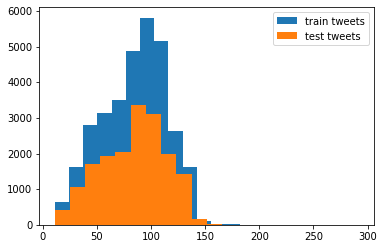

In [13]:
plt.hist(length_train,bins=20,label='train tweets')
plt.hist(length_test,bins=20,label='test tweets')
plt.legend()
plt.show();

In [14]:
#Lets combine train and test set
combi=train.append(test,ignore_index=True)

In [15]:
#function to remove patterns
def remove_pattern(input_txt,pattern):
    r=re.findall(pattern,input_txt)
    
    for i in r:
        input_txt=re.sub(i,'',input_txt)
    
    return input_txt

In [16]:
#Removing twitter handles. Tweets contain lot of user mentions . It does not provide any information value to us . So let us remove them
#combi['tidy_tweet']=np.vectorize(remove_pattern)(combi['tweet'],'@[\w]*')
#combi.head()

In [17]:
#Remove punctuation,special characters and numbers 
#combi['tidy_tweet']=combi['tidy_tweet'].str.replace('[^a-zA-Z#]',' ')
#combi.head()

In [18]:
 #removing short words.Words like hmm,oh don't have much menaing so lets remove short words 
#combi['tidy_tweet']=combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [19]:
#combi['tidy_tweet']

In [20]:
#tokenized_tweet=combi['tidy_tweet'].apply(lambda x:x.split())

In [21]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [22]:
lemmatizer = WordNetLemmatizer() 
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91999\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [23]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91999\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
def tweet_cleaner(text):
    newString=re.sub(r'@[A-Za-z0-9]+','',text)                     #removing user mentions
    newString= ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")]) #contraction mapping
    newString= re.sub(r'http\S+|www.\s+', '', newString)                   #removing links
    newString= re.sub(r"'s\b","",newString)                        #removing 's
    letters_only = re.sub("[^a-zA-Z#]", " ", newString)             #Fetching out only letters and #
    lower_case = letters_only.lower()                              #converting everything to lowercase
    tokens = [w for w in lower_case.split() if len(w)>3 and w not in stop_words ]#stopwords removal
    newString=''
    for i in tokens:                                                 
        newString=newString+lemmatizer.lemmatize(i)+' '            #converting words to lemma                               
    return newString.strip()                               

In [25]:
cleaned_tweets = []
for i in combi.tweet:
    cleaned_tweets.append(tweet_cleaner(i))
print(cleaned_tweets[:5])   #print top 5 records

['father dysfunctional selfish drag kid dysfunction #run', 'thanks #lyft credit cannot cause offer wheelchair van #disapointed #getthanked', 'bihday majesty', '#model love take time', 'factsguide society #motivation']


In [26]:
combi['tidy_tweet']= cleaned_tweets

In [27]:
#Visualizing all word data using wordcloud plot
all_words=''.join([text for text in combi['tidy_tweet']])

In [28]:
from wordcloud import WordCloud

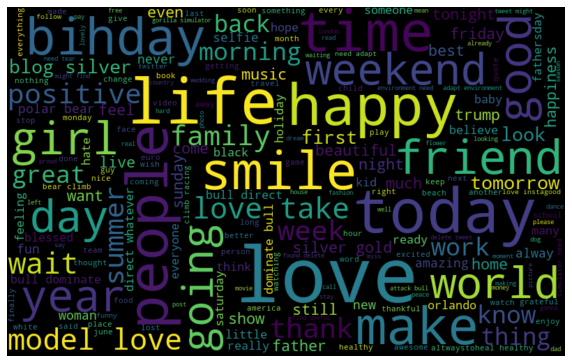

In [29]:
wordcloud=WordCloud(width=800,height=500,random_state=21,max_font_size=110).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

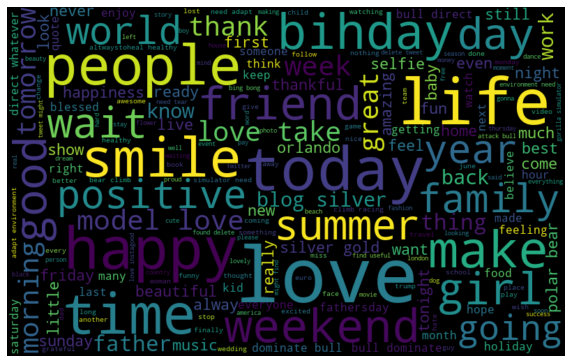

In [30]:
#Words in non-racist/sexist tweets
normal_words=''.join([word for word in combi['tidy_tweet'][combi['label']==0]])
wordcloud=WordCloud(width=800,height=500,random_state=21,max_font_size=110).generate(normal_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')

plt.show()

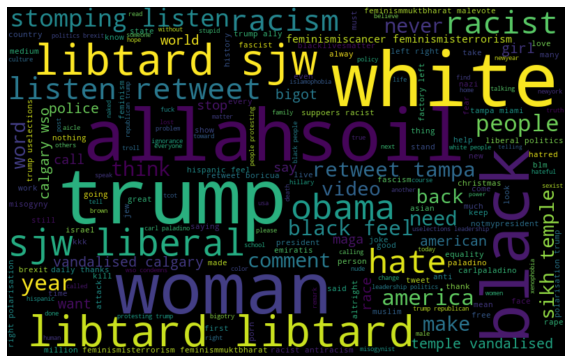

In [31]:
#Words in non-racist/sexist tweets
negative_words=''.join([word for word in combi['tidy_tweet'][combi['label']==1]])
wordcloud=WordCloud(width=800,height=500,random_state=21,max_font_size=110).generate(negative_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

### Understanding the impact of Hashtags on tweets sentiment


In [32]:
#function to collect hashtags:
def hashtag_extract(x):
    hashtags=[]
    for i in x:
        ht=re.findall(r'#(\w+)',i)
        hashtags.append(ht)
    return hashtags

In [33]:
#Extracting hashtags from non-racist tweets
HT_regular=hashtag_extract(combi['tidy_tweet'][combi['label']==0])
#Extracting hashtags from racist tweets
HT_negative=hashtag_extract(combi['tidy_tweet'][combi['label']==1])

In [34]:
HT_negative

[['cnn', 'michigan', 'tcot'],
 ['australia',
  'opkillingbay',
  'seashepherd',
  'helpcovedolphins',
  'thecove',
  'helpcovedolphins'],
 [],
 [],
 ['neverump', 'xenophobia'],
 ['love', 'peace'],
 [],
 ['race', 'identity', 'med'],
 ['altright', 'whitesupremacy'],
 ['linguistics', 'race', 'power', 'raciolinguistics'],
 ['brexit'],
 ['people', 'trump', 'republican'],
 ['michelleobama'],
 ['knicks', 'golf'],
 ['jewishsupremacist'],
 ['libtard', 'sjw', 'liberal', 'politics'],
 ['trash', 'hate'],
 [],
 [],
 ['stereotyping', 'prejudice', 'hope', 'hate', 'conflict'],
 ['pols', 'bluelivesmatter', 'draintheswamp', 'ferguson'],
 [],
 ['antisemitism', 'hocoschools', 'columbiamd', 'hocomd'],
 ['nazi', 'hatred', 'bigotry'],
 ['libtard', 'sjw', 'liberal', 'politics'],
 ['fyi', 'tcot'],
 ['topoli'],
 ['blacklivesmatter'],
 ['ushistory', 'eugenics'],
 ['biherism', 'bigotry', 'altright', 'potus', 'theresistance'],
 ['crime', 'officer'],
 [],
 ['black', 'retweet', 'tampa', 'miami'],
 ['allahsoil'],
 []

In [35]:
#unnesting list
HT_regular=sum(HT_regular,[])
HT_negative=sum(HT_negative,[])

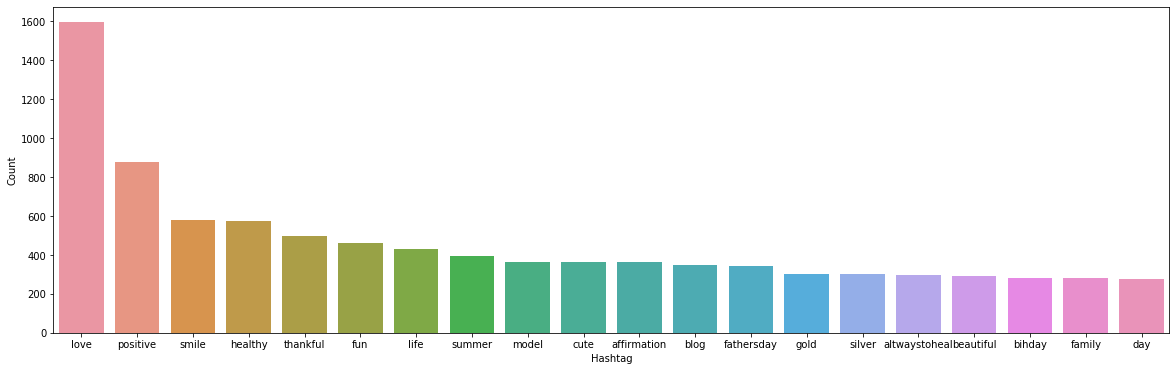

In [36]:
#Finding top 20 words in non racist tweets
a=nltk.FreqDist(HT_regular)
d=pd.DataFrame({'Hashtag':list(a.keys()),'Count':list(a.values())})
d=d.nlargest(columns='Count',n=20)
plt.figure(figsize=(20,6))
ax=sns.barplot(data=d,x="Hashtag",y="Count")
ax.set(ylabel='Count')
plt.show()

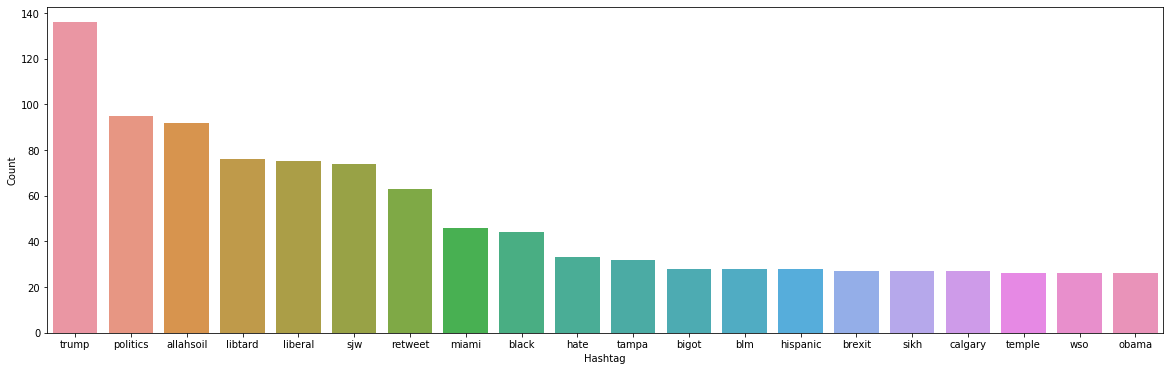

In [37]:
#Finding top 20 words in racist tweets
b=nltk.FreqDist(HT_negative)
e=pd.DataFrame({'Hashtag':list(b.keys()),'Count':list(b.values())})
e=e.nlargest(columns='Count',n=20)
plt.figure(figsize=(20,6))
ax=sns.barplot(data=e,x="Hashtag",y="Count")
ax.set(ylabel='Count')
plt.show()

In [38]:
bow_vectorizer=CountVectorizer(max_df=0.90,min_df=2,max_features=1000,stop_words='english')
bow=bow_vectorizer.fit_transform(combi['tidy_tweet'])

In [39]:
tfidf_vectorizer=TfidfVectorizer(max_df=0.90,min_df=2,max_features=1000,stop_words='english')
tfidf=tfidf_vectorizer.fit_transform(combi['tidy_tweet'])

In [40]:
#Word2Vec model
tokenized_tweet=combi['tidy_tweet'].apply(lambda x:x.split())


In [41]:
import gensim

In [42]:
model_w2v=gensim.models.Word2Vec(tokenized_tweet, window=5, min_count=2, sg=1, hs=0, negative=10, workers=2, seed=34, vector_size=200)

In [43]:
model_w2v.train(tokenized_tweet,total_examples=len(combi['tidy_tweet']),epochs=20)

(5810219, 6627900)

In [44]:
model_w2v.wv.most_similar(positive='dinner')

[('accompanied', 0.5844934582710266),
 ('favs', 0.5738847851753235),
 ('#cellar', 0.5731304883956909),
 ('#biall', 0.5683284997940063),
 ('feast', 0.56464022397995),
 ('noodle', 0.5571250319480896),
 ('spinach', 0.5556936860084534),
 ('spaghetti', 0.555598258972168),
 ('decorating', 0.5536421537399292),
 ('burrito', 0.5509325861930847)]

In [45]:
model_w2v.wv['food']

array([-0.11285514,  0.26350564,  0.95205015,  0.6039531 ,  0.05799366,
        0.22180207, -0.85355717,  0.04721054,  0.08527131, -0.21457903,
        0.46811703, -0.02501668,  0.04708165, -0.03469677, -0.07432832,
        0.49090484,  0.24205612,  0.3529107 ,  0.02110244, -0.28600228,
        0.02138666, -0.64599246,  0.38598874, -0.2953753 , -0.31056744,
       -0.17608528,  0.8056305 , -0.31368214,  0.43306705,  0.5165617 ,
        0.01028116, -0.78228027, -0.6435088 , -0.10564364, -0.786017  ,
        0.3631968 , -0.9175475 ,  0.18775897,  0.05414438,  0.03477969,
        0.4553612 ,  1.1480473 , -0.6448781 ,  0.28851628, -0.563683  ,
        0.32678223,  0.24223578, -0.8628809 , -0.7634976 , -0.17746712,
        0.87856513, -0.6421372 , -0.42271772,  0.28054053,  0.39615723,
        0.28264463, -0.2771069 , -0.70872843,  0.04485342,  0.29963422,
       -0.04742573, -1.1894006 ,  0.1220815 ,  0.26100594, -0.01343371,
        0.3866839 ,  0.3153341 ,  0.4696535 , -0.4633011 , -0.40

In [46]:
#Preparing vector for tweets
def word_vector(tokens,size):
    vec=np.zeros(size).reshape((1,size))
    count=0
    for word in tokens:
        try:
            vec+=model_w2v.wv[word].reshape((1,size))
            count+=1
        except KeyError:
            continue
    if count!=0:
        vec/=count
    return vec
        
        

In [47]:
wordvec_arrays=np.zeros((len(tokenized_tweet),200))
for i in range(len(tokenized_tweet)):
    wordvec_arrays[i:]=word_vector(tokenized_tweet[i],200)
    wordvec_df=pd.DataFrame(wordvec_arrays)

In [49]:
wordvec_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.167550,-0.117503,-0.050530,-0.091542,-0.333822,0.160011,-0.281205,0.142087,0.312006,-0.118916,...,0.475147,0.005056,-0.293524,-0.268674,0.121693,0.017430,-0.298638,-0.281612,0.182869,0.030417
1,-0.016996,-0.594700,0.120445,-0.064910,-0.217073,0.158159,-0.075077,0.084685,0.182940,-0.149593,...,0.084762,-0.054965,-0.053259,-0.108314,0.272461,-0.128115,-0.102889,-0.281326,0.151634,0.072831
2,0.134700,-0.251609,0.090478,-0.071821,-0.193209,-0.027402,-0.404434,-0.125550,0.641519,0.418918,...,0.056543,-0.454706,0.213584,-0.238924,0.415717,0.003982,-0.852759,-0.005570,-0.011356,0.332627
3,0.173448,-0.290467,0.249598,-0.189800,0.130850,-0.039159,-0.548199,0.184726,0.235018,0.097280,...,0.196599,-0.286875,-0.007925,-0.182439,0.761162,0.042350,-0.070173,-0.117961,0.225588,0.018802
4,-0.064383,-0.462080,0.162418,0.127549,-0.106874,0.238379,-0.102437,-0.087672,0.125033,-0.079773,...,0.340032,-0.192657,-0.272650,-0.022381,-0.067309,-0.016651,0.074613,-0.413305,0.399846,0.221455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49154,0.204721,-0.158469,0.423129,0.116398,-0.020080,0.475266,0.094021,-0.005508,0.221240,-0.268190,...,0.603456,0.025303,0.183339,-0.228992,0.326358,-0.018927,-0.444574,0.250011,0.125142,0.047549
49155,-0.255112,-0.169373,0.066936,-0.253502,0.082641,-0.049379,-0.206218,-0.048008,0.022038,-0.064860,...,0.177402,-0.199245,-0.035867,-0.005913,0.202969,0.035441,-0.562312,-0.247577,-0.158795,-0.165595
49156,-0.059121,-0.410231,0.001875,-0.195640,-0.099542,0.137195,-0.097580,0.033929,0.100366,-0.208075,...,0.361314,-0.083963,-0.315339,-0.193578,0.307358,-0.109415,-0.404383,-0.306108,-0.046393,-0.093960
49157,-0.040622,-0.511738,0.108039,0.197016,0.150647,0.069279,0.000681,0.206689,0.548460,-0.235184,...,0.180830,-0.010198,0.254032,-0.190312,0.430061,-0.242529,-0.153124,0.052280,-0.104644,0.250922


In [59]:
train_bow=bow[:31962,:]
test_bow=bow[31962:,:]

In [60]:
Xtrain_bow, Xtest_bow, y_train, y_test = train_test_split(train_bow,train['label'], test_size=0.33, random_state=42)

In [61]:
lreg=LogisticRegression()

In [62]:
lreg.fit(Xtrain_bow,y_train)

LogisticRegression()

In [63]:
prediction=lreg.predict_proba(Xtest_bow)

In [64]:
prediction_int = prediction[:,1]>=0.3

In [65]:
prediction_int.astype(np.int)

array([0, 0, 0, ..., 0, 0, 0])

In [66]:
f1_score(y_test,prediction_int)

0.5083399523431296

In [67]:
#Making predictions on test data
test_pred=lreg.predict_proba(test_bow)

In [68]:
testpred_int=test_pred[:,1]>0.3
testpred_int.astype(np.int)

array([0, 1, 0, ..., 0, 0, 0])

In [69]:
test['label']=testpred_int

In [70]:
train_tfidf=tfidf[:31962,:]
test_tfidf=tfidf[31962:,:]

In [71]:
Xtrain_tfidf, Xtest_tfidf, y_train, y_test = train_test_split(train_tfidf,train['label'], test_size=0.33, random_state=42)

In [72]:
lreg.fit(Xtrain_tfidf,y_train)

LogisticRegression()

In [73]:
prediction=lreg.predict_proba(Xtest_tfidf)

In [74]:
prediction_int=prediction[:,1]>=0.3
prediction_int.astype(np.int)

array([0, 0, 0, ..., 0, 0, 0])

In [75]:
f1_score(y_test,prediction_int)

0.5119341563786007

Word2vec logistic regression

In [76]:
train_w2v=wordvec_df.iloc[:31962,:]
test_w2v=wordvec_df.iloc[31962:,:]

In [77]:
Xtrain_w2v, Xtest_w2v, y_train, y_test = train_test_split(train_w2v,train['label'], test_size=0.33, random_state=42)

In [78]:
lreg.fit(Xtrain_w2v,y_train)

LogisticRegression()

In [79]:
prediction=lreg.predict_proba(Xtest_w2v)

In [80]:
prediction_int=prediction[:,1]>=0.3
prediction_int.astype(np.int)

array([0, 0, 0, ..., 0, 0, 0])

In [81]:
f1_score(y_test,prediction_int)

0.6184738955823292

BY comparing above we could see that our Word2Vec model performs best


In [88]:
from sklearn.svm import SVC

In [89]:
#SVC BOW
svc=SVC(kernel='linear',C=1,probability=True).fit(Xtrain_bow,y_train)

In [90]:
prediction=svc.predict_proba(Xtest_bow)

In [91]:
prediction_int=prediction[:,1]>=0.3
prediction_int.astype(np.int)

array([0, 0, 0, ..., 0, 0, 0])

In [92]:
f1_score(y_test,prediction_int)

0.49443969204448246

In [93]:
#SVC tfidf
svc=SVC(kernel='linear',C=1,probability=True).fit(Xtrain_tfidf,y_train)
prediction=svc.predict_proba(Xtest_tfidf)
prediction_int=prediction[:,1]>=0.3
prediction_int.astype(np.int)
f1_score(y_test,prediction_int)

0.48068669527896996

In [94]:
#SVC word2vec
svc=SVC(kernel='linear',C=1,probability=True).fit(Xtrain_w2v,y_train)
prediction=svc.predict_proba(Xtest_w2v)
prediction_int=prediction[:,1]>=0.3
prediction_int.astype(np.int)
f1_score(y_test,prediction_int)

0.6239316239316239

Word2vec performs well in this case also. And d2v performed very pooor in LR so lets leave that 

In [95]:
#Randomforest BOW
from sklearn.ensemble import RandomForestClassifier

In [96]:
rfc=RandomForestClassifier(n_estimators=400,random_state=42).fit(Xtrain_bow,y_train)
prediction=rfc.predict(Xtest_bow)
f1_score(y_test,prediction)

0.5193452380952381

In [97]:
rfc=RandomForestClassifier(n_estimators=400,random_state=42).fit(Xtrain_tfidf,y_train)
prediction=rfc.predict(Xtest_tfidf)
f1_score(y_test,prediction)

0.5249788314987298

In [98]:
rfc=RandomForestClassifier(n_estimators=400,random_state=42).fit(Xtrain_w2v,y_train)
prediction=rfc.predict(Xtest_w2v)
f1_score(y_test,prediction)

0.5454545454545455

XGBOOST 

In [99]:
from xgboost import XGBClassifier

In [100]:
xgb_model=XGBClassifier(max_depth=6,n_estimators=1000).fit(Xtrain_bow,y_train)
prediction=xgb_model.predict(Xtest_bow)
f1_score(y_test,prediction)

C:\Users\91999\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:41:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.5056082830025884

In [101]:
#XGB TF-IDF
xgb_model=XGBClassifier(max_depth=6,n_estimators=1000).fit(Xtrain_tfidf,y_train)
prediction=xgb_model.predict(Xtest_tfidf)
f1_score(y_test,prediction)

C:\Users\91999\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:41:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.5129924559932942

In [102]:
# XGB Word2Vec
xgb_model=XGBClassifier(max_depth=6,n_estimators=1000).fit(Xtrain_w2v,y_train)
prediction=xgb_model.predict(Xtest_w2v)
f1_score(y_test,prediction)

C:\Users\91999\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:41:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.6634066829665851

In [104]:
import xgboost as xgb

In [105]:
dtrain=xgb.DMatrix(Xtrain_w2v,label=y_train)
dvalid=xgb.DMatrix(Xtest_w2v,label=y_test)
dtest=xgb.DMatrix(test_w2v)

In [106]:
#parameters we are going to tune
params={'objective':'binary:logistic',
        'max_depth':6,
        'min_child_weight':1,
        'eta':.3,
        'subsample':1,
        'colsample_bytree':1}

In [107]:
#Custom evaluation metric to evaluate F1  score
def custom_eval(preds,dtrain):
    labels=dtrain.get_label().astype(np.int)
    preds=(preds>0.3).astype(np.int)
    return [('f1 score',f1_score(labels,preds))] 

In [108]:
gridsearch_params=[(max_depth,min_child_weight) for max_depth in range(6,10) for min_child_weight in range(5,8)]

In [109]:
max_f1=0
best_params=None
for max_depth,min_child_weight in gridsearch_params:
    print("CV with max_depth={},min_child_weight={}".format(max_depth,min_child_weight))

CV with max_depth=6,min_child_weight=5
CV with max_depth=6,min_child_weight=6
CV with max_depth=6,min_child_weight=7
CV with max_depth=7,min_child_weight=5
CV with max_depth=7,min_child_weight=6
CV with max_depth=7,min_child_weight=7
CV with max_depth=8,min_child_weight=5
CV with max_depth=8,min_child_weight=6
CV with max_depth=8,min_child_weight=7
CV with max_depth=9,min_child_weight=5
CV with max_depth=9,min_child_weight=6
CV with max_depth=9,min_child_weight=7


In [110]:
params['max_depth']=max_depth
params['min_child_weight']=min_child_weight

In [112]:
#params{'colsample':0.9,'colsample_bytree':0.5,'eta':0.1,'max_depth':8,'min_child_weight':6,'objective':'binary:logistic','subsample':0.9}

In [113]:
params={'objective':'binary:logistic',
        'max_depth':8,
        'min_child_weight':6,
        'eta':.1,
        'subsample':.9,
        'colsample_bytree':0.5,
        'colsample':0.9
        }

In [139]:
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round= 10000,
    maximize=True,
    evals=[(dvalid, "Validation")],
    early_stopping_rounds=600
)

[23:03:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:03:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	Validation-logloss:0.61602
[1]	Validation-logloss:0.55159
[2]	Validation-logloss:0.49825
[3]	Validation-logloss:0.45278
[4]	Validation-logloss:0.41407
[5]	Validation-logloss:0.38098
[6]	Validation-logloss:0.35235
[7]	Validation-logloss:0.32710
[8]	Validation-logloss:0.30523
[9]	Validation-logloss

[231]	Validation-logloss:0.12668
[232]	Validation-logloss:0.12665
[233]	Validation-logloss:0.12669
[234]	Validation-logloss:0.12676
[235]	Validation-logloss:0.12674
[236]	Validation-logloss:0.12685
[237]	Validation-logloss:0.12691
[238]	Validation-logloss:0.12694
[239]	Validation-logloss:0.12702
[240]	Validation-logloss:0.12706
[241]	Validation-logloss:0.12712
[242]	Validation-logloss:0.12707
[243]	Validation-logloss:0.12721
[244]	Validation-logloss:0.12722
[245]	Validation-logloss:0.12721
[246]	Validation-logloss:0.12733
[247]	Validation-logloss:0.12739
[248]	Validation-logloss:0.12755
[249]	Validation-logloss:0.12769
[250]	Validation-logloss:0.12774
[251]	Validation-logloss:0.12775
[252]	Validation-logloss:0.12792
[253]	Validation-logloss:0.12783
[254]	Validation-logloss:0.12788
[255]	Validation-logloss:0.12789
[256]	Validation-logloss:0.12787
[257]	Validation-logloss:0.12796
[258]	Validation-logloss:0.12798
[259]	Validation-logloss:0.12804
[260]	Validation-logloss:0.12814
[261]	Vali

[480]	Validation-logloss:0.13684
[481]	Validation-logloss:0.13697
[482]	Validation-logloss:0.13701
[483]	Validation-logloss:0.13704
[484]	Validation-logloss:0.13704
[485]	Validation-logloss:0.13707
[486]	Validation-logloss:0.13709
[487]	Validation-logloss:0.13713
[488]	Validation-logloss:0.13717
[489]	Validation-logloss:0.13728
[490]	Validation-logloss:0.13728
[491]	Validation-logloss:0.13734
[492]	Validation-logloss:0.13740
[493]	Validation-logloss:0.13739
[494]	Validation-logloss:0.13737
[495]	Validation-logloss:0.13736
[496]	Validation-logloss:0.13743
[497]	Validation-logloss:0.13739
[498]	Validation-logloss:0.13739
[499]	Validation-logloss:0.13737
[500]	Validation-logloss:0.13740
[501]	Validation-logloss:0.13748
[502]	Validation-logloss:0.13752
[503]	Validation-logloss:0.13757
[504]	Validation-logloss:0.13759
[505]	Validation-logloss:0.13765
[506]	Validation-logloss:0.13769
[507]	Validation-logloss:0.13772
[508]	Validation-logloss:0.13779
[509]	Validation-logloss:0.13780
[510]	Vali

In [115]:
xgb_model2=XGBClassifier(max_depth=8,min_child_weight=6,eta=.1,colsample_bytree=.5,colsample=.9,n_estimators=1000).fit(Xtrain_w2v,y_train)
prediction=xgb_model2.predict(Xtest_w2v)
f1_score(y_test,prediction)

C:\Users\91999\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:48:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:48:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.6633663366336634

In [118]:
test_pred1=xgb_model.predict(dtest)

In [119]:
test_pred1

array([0.16881613, 0.1685464 , 0.17236167, ..., 0.23685777, 0.16555141,
       0.19691405], dtype=float32)

In [134]:
test['label']=(test_pred1>=0.3).astype(np.int)

In [135]:
test['label'].value_counts()

0    15786
1     1411
Name: label, dtype: int64

In [136]:
submission=test[['id','label']]

In [137]:
submission.to_csv('sub_xgb_w2v.csv',index=False)